In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def compute_graph_covariance(df: pd.DataFrame, time_col: str = 't') -> dict:
    """
    Computes a 'graph covariance'-like matrix for each unique time step in `df`,
    returning each matrix as a DataFrame (so .loc indexing is supported).
    
    Steps:
      1. Split the data by unique time values,
      2. For each time step, convert the sub-DataFrame (minus the time column)
         to a NumPy array,
      3. Subtract the mean from each column (center the data),
      4. Normalize each column by its standard deviation,
      5. Compute the covariance-like matrix for that time step,
      6. Return a dictionary keyed by time with the resulting DataFrame.

    Returns
    -------
    dict
        Dictionary where each key is a unique time value and the value is a
        DataFrame containing the covariance-like matrix.
    """
    # Identify all columns other than time_col
    other_cols = [col for col in df.columns if col != time_col]
    
    # Split data into time steps
    unique_times = df[time_col].unique()
    gc_dict = {}

    for t_value in unique_times:
        # Subset the DataFrame to the current time step
        subset_df = df[df[time_col] == t_value].drop(columns=[time_col])
        data_t = subset_df.values.astype(float)

        if data_t.shape[0] < 2:
            continue

        # Mean-center the data
        n = data_t.shape[0]
        mean = data_t.mean(axis=0, keepdims=True)
        data_centered = data_t - mean

        # Normalize each column
        stds = data_centered.std(axis=0, ddof=1, keepdims=True)
        
        # Avoid division by zero
        stds[stds == 0] = 1.0
        data_centered /= stds

        # Compute the covariance-like matrix
        graph_covariance = (data_centered.T @ data_centered) / (n - 1)

        # Convert to DataFrame
        cov_df = pd.DataFrame(graph_covariance, 
                              index=subset_df.columns, 
                              columns=subset_df.columns)
        
        # Store the DataFrame
        gc_dict[t_value] = cov_df

    return gc_dict

In [9]:
df = pd.read_csv("../non_categorical_gen_data.csv")
gc_matrices = compute_graph_covariance(df, time_col="t")

print("Graph covariance matrices by time:")
for t, mat in gc_matrices.items():
    print(f"\nTime {t}:")
    print(mat.round(3))

Graph covariance matrices by time:

Time 1:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000  0.017  0.970  0.705  0.971  0.884  0.002
X2  0.017  1.000  0.016  0.018  0.019  0.021  0.002
X3  0.970  0.016  1.000  0.688  0.942  0.859 -0.004
X4  0.705  0.018  0.688  1.000  0.689  0.627  0.003
X5  0.971  0.019  0.942  0.689  1.000  0.858  0.004
X6  0.884  0.021  0.859  0.627  0.858  1.000 -0.000
X7  0.002  0.002 -0.004  0.003  0.004 -0.000  1.000

Time 2:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000 -0.017  0.972  0.834  0.963  0.850  0.002
X2 -0.017  1.000 -0.010 -0.024 -0.016 -0.004 -0.003
X3  0.972 -0.010  1.000  0.811  0.935  0.828  0.001
X4  0.834 -0.024  0.811  1.000  0.801  0.705  0.001
X5  0.963 -0.016  0.935  0.801  1.000  0.818 -0.002
X6  0.850 -0.004  0.828  0.705  0.818  1.000  0.018
X7  0.002 -0.003  0.001  0.001 -0.002  0.018  1.000

Time 3:
       X1     X2     X3     X4     X5     X6     X7
X1  1.000  0.016  0.969  0.893  0.947  0.793  0.009
X2

In [10]:
times = sorted(gc_matrices.keys())

gc_12 = [gc_matrices[t].loc["X1","X2"] for t in times]  # (X1, X2)
gc_13 = [gc_matrices[t].loc["X1","X3"] for t in times]  # (X1, X3)
gc_14 = [gc_matrices[t].loc["X1","X4"] for t in times]  # (X1, X4)
gc_15 = [gc_matrices[t].loc["X1","X5"] for t in times]  # (X1, X5)
gc_16 = [gc_matrices[t].loc["X1","X6"] for t in times]  # (X1, X6)
gc_17 = [gc_matrices[t].loc["X1","X7"] for t in times]  # (X1, X7)

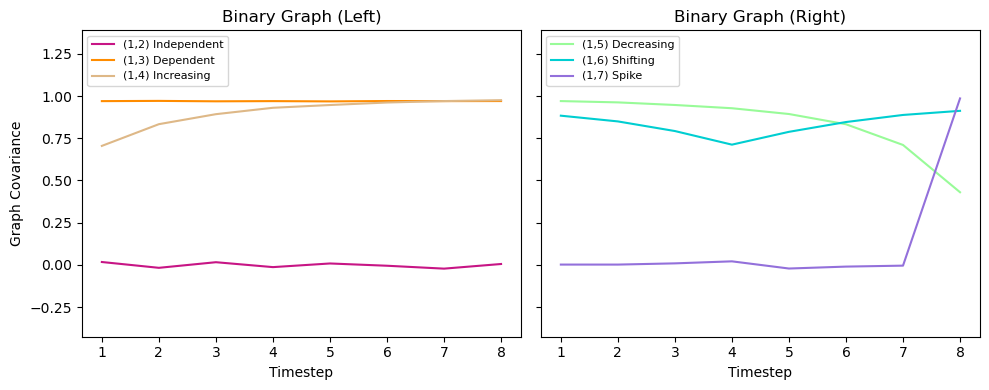

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Left: (X1,X2), (X1,X3), (X1,X4)
ax1.plot(times, gc_12, color='mediumvioletred', label='(1,2) Independent')
ax1.plot(times, gc_13, color='darkorange', label='(1,3) Dependent')
ax1.plot(times, gc_14, color='burlywood', label='(1,4) Increasing')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Graph Covariance')
ax1.set_title('Binary Graph (Left)')
ax1.legend(loc='upper left', fontsize='8')

# Right: (X1,X5), (X1,X6), (X1,X7)
ax2.plot(times, gc_15, color='palegreen', label='(1,5) Decreasing')
ax2.plot(times, gc_16, color='darkturquoise', label='(1,6) Shifting')
ax2.plot(times, gc_17, color='mediumpurple', label='(1,7) Spike')
ax2.set_xlabel('Timestep')
ax2.set_title('Binary Graph (Right)')
ax2.legend(loc='upper left', fontsize='8')

# Combine all data to determine the overall min and max
all_data = np.concatenate([gc_12, gc_13, gc_14, gc_15, gc_16, gc_17])
global_min = np.min(all_data)
global_max = np.max(all_data)

# Calculate a 20% margin on the range
data_range = global_max - global_min
margin = 0.4 * data_range

# Set the y-axis limits with an extra 20% margin
y_lower = global_min - margin
y_upper = global_max + margin
ax1.set_ylim(y_lower, y_upper)
ax2.set_ylim(y_lower, y_upper)

plt.tight_layout()
plt.show()